
* Trasformer encoder = a stack of multiple identical layers \\
* Two layer= = multi-head self-attention pooling + positionwise feed_forward network. \\
A residual connection is employed around both sublayers(= Add & Norm) \\
For any input $x \in \mathbb{R}^d $ at any position of the sequence, the residual connection is $x + sublayer(x)$ and Layer normalization \\
=> Transformer encoder outputs a d-dimensional vector representation for each position of the input sequence. 

* Transforemr decoder = a stack of multiple identical layers with residual conenctions and layer normalizations \\
decorder inserts a third sublayer(=encoder-decoder attention) \\
Encoder-decoder attention = queries are from the outputs of the previous decoder layers, keys and values are from the transformer encoder outputs \\
In the decoder self-attention, quereis keys and values are all from the outputs of the previous decoder layer \\
each position in the decoder is allowed to only attend to all positions in the decoder up to that position

In [1]:
pip install --upgrade d2l==1.0.0a0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 92 kB 805 kB/s 
     |████████████████████████████████| 120 kB 27.5 MB/s 
     |████████████████████████████████| 1.6 MB 45.8 MB/s 
     |████████████████████████████████| 82 kB 811 kB/s 


In [2]:
pip install matplotlib_inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Attention Score function


## masked_softmax(Hands on) 


In [3]:
import torch 
import torch.nn as nn
def masked_softmax(X, valid_lens):
    # X: 3D tensor, valid_lens: 1D or 2D tensor
    # [X]_{ij} = a(k_i, k_i)
    # X[1] = query dim;  
    # The mask is applied to the query dim, because there are meaninglses tokens and we want to delete attention pooling follod by this axis.
    # X[2] = key dim 
    def _sequence_mask(X, valid_len, value=0):
        maxlen = X.size(1) # number of keys 
        mask = torch.arange((maxlen), dtype=torch.float32,
                            device=X.device)[None, :] < valid_len[:, None]
                            #( 0, 1, 2, 3) < (2 2 3 3)^T -> 
        X[~mask] = value
        return X

    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
           # On the last axis, replace masked elements with a very large negative
        # value, whose exponentiation outputs 0
        X = _sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

This meaning is to set the first batch's val len to be 2 and the second batch's val len to be 3.

In [4]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))
# [2,3] 

tensor([[[0.5752, 0.4248, 0.0000, 0.0000],
         [0.3916, 0.6084, 0.0000, 0.0000]],

        [[0.3053, 0.4887, 0.2060, 0.0000],
         [0.3930, 0.2496, 0.3574, 0.0000]]])

In [5]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]]))

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.4882, 0.2572, 0.2546, 0.0000]],

        [[0.3299, 0.6701, 0.0000, 0.0000],
         [0.2000, 0.3086, 0.1646, 0.3268]]])

## DotProductAttention

In [6]:
import math 
import d2l
class DotProductAttention(nn.Module):
    """Scaled dot product attention."""
    def __init__(self, dropout, num_heads=None):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.num_heads = num_heads  # To be covered later

    # Shape of queries: (batch_size, no. of queries, d)
    # Shape of keys: (batch_size, no. of key-value pairs, d)
    # Shape of values: (batch_size, no. of key-value pairs, value dimension)
    # Shape of valid_lens: (batch_size,) or (batch_size, no. of queries)
    
    def forward(self, queries, keys, values, valid_lens=None,
                window_mask=None):
        d = queries.shape[-1]
        # Swap the last two dimensions of keys with keys.transpose(1, 2)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
        if window_mask is not None:  # To be covered later
            num_windows = window_mask.shape[0]
            n, num_queries, num_kv_pairs = scores.shape
            # Shape of window_mask: (num_windows, no. of queries,
            # no. of key-value pairs)
            scores = scores.reshape((n // (num_windows * self.num_heads), num_windows, self.
    num_heads, num_queries, num_kv_pairs)) + window_mask.unsqueeze(1).unsqueeze(0)
            scores = scores.reshape((n, num_queries, num_kv_pairs))
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

# Positionwise Feed-Forward Networks(Hands on)


In [7]:
import math
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [8]:
class PositionWiseFFN(nn.Module):
  def __init__(self, ffn_num_hiddens, ffn_num_outputs):
    super().__init__()
    self.densel = nn.LazyLinear(ffn_num_hiddens)
    self.relu = nn.ReLU()
    self.dense2 = nn.LazyLinear(ffn_num_outputs)
  def forward(self,X):
    return self.dense2(self.relu(self.densel(X)))


In [9]:
ffn = PositionWiseFFN(4, 8)
ffn.eval()
ffn(torch.ones((2, 3, 4)))[0]

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


tensor([[-0.3684,  0.2220,  0.4756, -0.4644, -0.0906,  0.1571,  0.3588,  0.2492],
        [-0.3684,  0.2220,  0.4756, -0.4644, -0.0906,  0.1571,  0.3588,  0.2492],
        [-0.3684,  0.2220,  0.4756, -0.4644, -0.0906,  0.1571,  0.3588,  0.2492]],
       grad_fn=<SelectBackward0>)

# Residual Conenction and Layer Normalization

In [10]:
ln = nn.LayerNorm(2)
bn = nn.LazyBatchNorm1d()
X = torch.tensor([[1, 2], [2, 3]], dtype=torch.float32)
# Compute mean and variance from X in the training mode
print('layer norm:', ln(X), '\nbatch norm:', bn(X))

layer norm: tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward0>) 
batch norm: tensor([[-1.0000, -1.0000],
        [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward0>)



- column = one example \\
- row = one feature dimension 

* BN


* M = batch size \\
* K = A feature dimension \\
$ u_k = 1/M \sum_{m=1}^N x_{m,k} \\
\sigma_k^2 = 1/M \sum_{m=1}^K (x_{m,k} - u_i)^2 $


* LN 

$ u_i = 1/K \sum_{k=1}^K x_{i,k} \\
\sigma_i^2 = 1/k \sum_{k=1}^K (x_{i,k} - u_i)^2 $ \\
$ u_i = 1/K \sum_{k=1}^K x_{i,k} \\
\sigma_i^2 = 1/k \sum_{k=1}^K (x_{i,k} - u_i)^2 $ \\





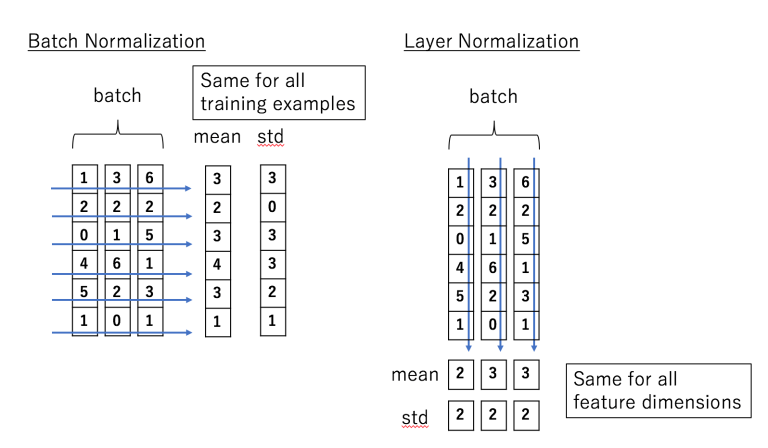

In [11]:
class AddNorm(nn.Module):
    """Residual connection followed by layer normalization."""
    def __init__(self, norm_shape, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(norm_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

In [12]:
add_norm = AddNorm([3, 4], 0.5)  # Normalized_shape is input.size()[1:]
add_norm.eval()
add_norm(torch.ones((2, 3, 4)), torch.ones((2, 3, 4))).shape

torch.Size([2, 3, 4])

#TransformerEncoderBlock(Hands on)


In [13]:
class TransformerEncoderBlock(nn.Module):
  def __init__(self, num_hiddens, ffn_num_hiddens,num_heads, dropout, use_bias=False):
    super().__init__()
    self.attention = d2l.MultiHeadAttention(num_hiddens, num_heads, dropout, use_bias)
    self.addnorml = AddNorm(num_hiddens, dropout)
    self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
    self.addnorm2 = AddNorm(num_hiddens, dropout)
  def forward(self,X,valid_lens):
    Y= self.addnorml(X,self.attention(X,X,X,valid_lens))
    return self.addnorm2(Y,self.ffn(Y))                                        


In [14]:
X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 2])
encoder_blk = TransformerEncoderBlock(24, 48, 8, 0.5)
encoder_blk.eval()

d2l.check_shape(encoder_blk(X, valid_lens), X.shape)
print(encoder_blk(X,valid_lens).shape, X.shape)

torch.Size([2, 100, 24]) torch.Size([2, 100, 24])


* torch.repeat_interleave(input, repeats, dim=None, *, output_size=None) → Tensor
Repeat elements of a tensor.




```
X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
```



## TransfomrerEncoder(Hands on)

In [15]:
class TransformerEncoder(d2l.Encoder):
  def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens, num_heads, num_blks, dropout, use_bias= False):
    super().__init__()
    self.num_hiddens = num_hiddens
    self.embedding = nn.Embedding(vocab_size, num_hiddens)
    self.pos_encoding = d2l.PositionalEncoding(num_hiddens,dropout)
    self.blks = nn.Sequential()
    for i in range(num_blks):
      self.blks.add_module('block'+str(i), TransformerEncoderBlock(num_hiddens, ffn_num_hiddens, num_heads, dropout, use_bias))
    
  def forward(self, X, valid_lens):
   X = self.pos_encoding(self.embedding(X)*math.sqrt(self.num_hiddens))
   self.attention_weights = [None]*len(self.blks)
   for i, blk in enumerate(self.blks):
     X= blk(X,valid_lens)
     self.attention_weights[i] = blk.attention.attention.attention_weights
   return X



In [16]:
encoder = TransformerEncoder(200, 24, 48, 8, 2, 0.5)
d2l.check_shape(encoder(torch.ones((2, 100), dtype=torch.long), valid_lens),
                (2, 100, 24))

# Decoder 


## TransformerDecoderBlock(Hands on)

In [17]:
class TransformerDecoderBlock(nn.Module):
    # The i-th block in the transformer decoder
    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout, i):
        super().__init__()
        self.i = i
        self.attention1 = d2l.MultiHeadAttention(num_hiddens, num_heads,
                                                 dropout)
        self.addnorm1 = AddNorm(num_hiddens, dropout)
        self.attention2 = d2l.MultiHeadAttention(num_hiddens, num_heads,
                                                 dropout)
        self.addnorm2 = AddNorm(num_hiddens, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        # Feed-Forward network(FFN)
        self.addnorm3 = AddNorm(num_hiddens, dropout)

    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        # During training, all the tokens of any output sequence are processed
        # at the same time, so state[2][self.i] is None as initialized. When
        # decoding any output sequence token by token during prediction,
        # state[2][self.i] contains representations of the decoded output at
        # the i-th block up to the current time step
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), dim=1)
        state[2][self.i] = key_values
        if self.training:
            batch_size, num_steps, _ = X.shape
            # Shape of dec_valid_lens: (batch_size, num_steps), where every
            # row is [1, 2, ..., num_steps]
            dec_valid_lens = torch.arange(
                1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None
        # Self-attention
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        # Encoder-decoder attention. Shape of enc_outputs:
        # (batch_size, num_steps, num_hiddens)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

In [18]:
decoder_blk = TransformerDecoderBlock(24, 48, 8, 0.5, 0)
X = torch.ones((2, 100, 24))
state = [encoder_blk(X, valid_lens), valid_lens, [None]]
d2l.check_shape(decoder_blk(X, state)[0], X.shape)

## TransfomrerDecoder(Hands on)

In [19]:
class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens, num_heads,
                 num_blks, dropout):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.num_blks = num_blks
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module("block"+str(i), TransformerDecoderBlock(
                num_hiddens, ffn_num_hiddens, num_heads, dropout, i))
        self.dense = nn.LazyLinear(vocab_size)
      
    def init_state(self, enc_outputs, enc_valid_lens):
        return [ enc_outputs, enc_valid_lens, [None]*self.num_blks]
      
    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X)*math.sqrt(self.num_hiddens))
        self._attention_weights = [[None]*len(self.blks) for _ in range(2)]
        for i, blk in enumerate(self.blks):
          X,state = blk(X,state)
          self._attention_weights[0][i] = blk.attention1.attention.attention_weights
          self._attention_weights[1][i] = blk.attention2.attention.attention_weights
        return self.dense(X), state
    def attention_weights(self):
      return self._attention_weights  

**Parameter** \\
1) vocab_size \\
2) num_hiddens(=feature dimension) \\
3) ffn_num_hiddens \\
4) num_head \\
5) num_blks \\
6) dropout 

# Training


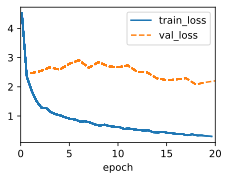

In [20]:
data = d2l.MTFraEng(batch_size=128)
num_hiddens, num_blks, dropout = 256, 2, 0.2
ffn_num_hiddens, num_heads = 64, 4
encoder = TransformerEncoder(
    len(data.src_vocab), num_hiddens, ffn_num_hiddens, num_heads,
    num_blks, dropout)
decoder = TransformerDecoder(
    len(data.tgt_vocab), num_hiddens, ffn_num_hiddens, num_heads,
    num_blks, dropout)
model = d2l.Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
                    lr=0.001)
trainer = d2l.Trainer(max_epochs=20, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

In [21]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
    data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{d2l.bleu(" ".join(translation), fr, k=2):.3f}')

go . => ['va', '!'], bleu,1.000
i lost . => ['je', 'suis', 'perdu', '.'], bleu,0.537
he's calm . => ['<unk>', '.'], bleu,0.000
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000
